In [1]:
import os
import caer
import numpy as np
import canaro
import cv2 as cv
import gc

2025-07-11 09:39:10.795856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752206950.819261   16040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752206950.826144   16040 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752206950.843785   16040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752206950.843812   16040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752206950.843815   16040 computation_placer.cc:177] computation placer alr

In [2]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'archive/simpsons_dataset'

In [3]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('abraham_grampa_simpson', 913),
 ('apu_nahasapeemapetilon', 623),
 ('barney_gumble', 106),
 ('agnes_skinner', 42)]

In [4]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'agnes_skinner']

In [5]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] 913 files found in 0.004353761672973633s
[INFO] 623 files found in 0.0015819072723388672s
[INFO] 106 files found in 0.0002675056457519531s
[INFO] 42 files found in 0.0001518726348876953s
----------------------------------------------
[INFO] 1684 files preprocessed! Took 0m 3s


In [6]:
len(train)

1684

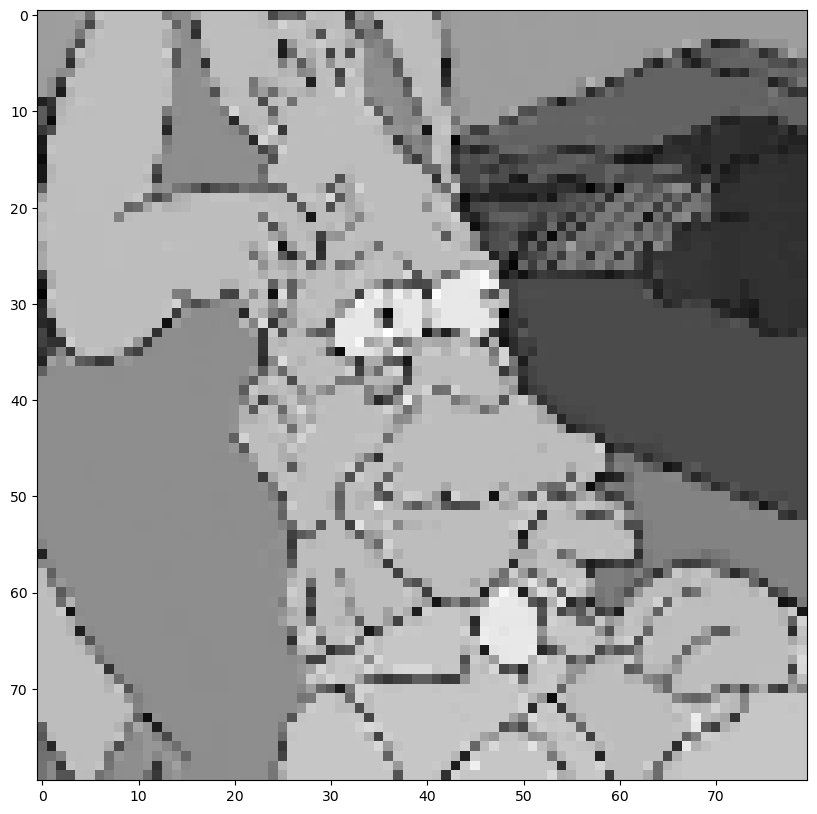

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [8]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [9]:
from tensorflow.keras.utils import to_categorical
# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [10]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=0.2)

In [11]:
x_train

array([[[[0.5254902 ],
         [0.5254902 ],
         [0.5294118 ],
         ...,
         [0.5294118 ],
         [0.5294118 ],
         [0.5294118 ]],

        [[0.5254902 ],
         [0.5254902 ],
         [0.5294118 ],
         ...,
         [0.5294118 ],
         [0.5294118 ],
         [0.5294118 ]],

        [[0.5254902 ],
         [0.5254902 ],
         [0.5294118 ],
         ...,
         [0.5294118 ],
         [0.5294118 ],
         [0.5294118 ]],

        ...,

        [[0.38039216],
         [0.38431373],
         [0.44705883],
         ...,
         [0.654902  ],
         [0.654902  ],
         [0.654902  ]],

        [[0.39215687],
         [0.4627451 ],
         [0.19215687],
         ...,
         [0.654902  ],
         [0.654902  ],
         [0.654902  ]],

        [[0.39215687],
         [0.4627451 ],
         [0.29411766],
         ...,
         [0.654902  ],
         [0.654902  ],
         [0.654902  ]]],


       [[[0.2901961 ],
         [0.27058825],
         [0.07

In [12]:
del train
del featureSet
del labels
gc.collect()

0

In [13]:
# Image data generator
BATCH_SIZE = 32
EPOCHS = 10
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [14]:
# Creating the model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, 
                                          channels=channels, 
                                          output_dim=len(characters),
                                         loss = 'binary_crossentropy',
                                         decay = 1e-6,
                                         learning_rate=0.001,
                                         momentum = 0.9,
                                         nesterov=True)

/home/aditya/miniconda3/envs/opencv-course/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-11 09:39:18.258552: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/aditya/miniconda3/envs/opencv-course/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,585,124 (67.08 MB)

 Trainable params: 17,585,124 (67.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [17]:
training = model.fit(train_gen, 
                    steps_per_epoch = len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (x_val, y_val),
                    validation_steps = len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10


/home/aditya/miniconda3/envs/opencv-course/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4711 - loss: 0.5795 - val_accuracy: 0.5237 - val_loss: 0.4305 - learning_rate: 0.0100
Epoch 2/10
 1/42 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.5000 - loss: 0.4115

/home/aditya/miniconda3/envs/opencv-course/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5000 - loss: 0.4115 - val_accuracy: 0.5237 - val_loss: 0.4301 - learning_rate: 0.0100
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5441 - loss: 0.4207 - val_accuracy: 0.6627 - val_loss: 0.4161 - learning_rate: 0.0100
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.7188 - loss: 0.3586 - val_accuracy: 0.6627 - val_loss: 0.4101 - learning_rate: 0.0100
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6604 - loss: 0.3939 - val_accuracy: 0.7160 - val_loss: 0.3512 - learning_rate: 0.0100
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.6250 - loss: 0.3315 - val_accuracy: 0.7071 - val_loss: 0.3527 - learning_rate: 0.0100
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7262 - loss: 0.3499 - val_accuracy: 0.7219 - val_loss: 0.3305 - learning_rate: 0.0100
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7500 - loss: 0.3369 - val_accuracy: 0.748

In [18]:
characters

['abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'agnes_skinner']

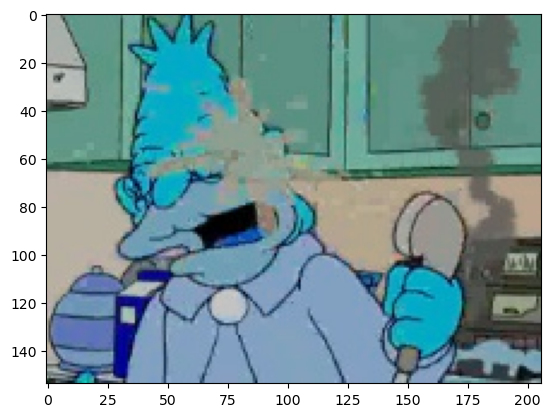

In [19]:
test_path = r'archive/kaggle_simpson_testset/kaggle_simpson_testset/abraham_grampa_simpson_7.jpg'

img = cv.imread(test_path)
plt.imshow(img, cmap='gray')
plt.show()

In [20]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [21]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


In [22]:
predictions

array([[1., 0., 0., 0.]], dtype=float32)

In [23]:
print(characters[np.argmax(predictions[0])])

abraham_grampa_simpson
